# Preparing the dataset for hippocampus segmentation

In this notebook you will use the skills and methods that we have talked about during our EDA Lesson to prepare the hippocampus dataset using Python. Follow the Notebook, writing snippets of code where directed so using Task comments, similar to the one below, which expects you to put the proper imports in place. Write your code directly in the cell with TASK comment. Feel free to add cells as you see fit, but please make sure that code that performs that tasked activity sits in the same cell as the Task comment.


In [1]:
# TASK: Import the following libraries that we will use: nibabel, matplotlib, num
import pydicom
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.ma as ma
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import nibabel as nib
from PIL import Image
import math
from nibabel.testing import data_path
import scipy.ndimage as nd
import glob
import shutil

It will help your understanding of the data a lot if you were able to use a tool that allows you to view NIFTI volumes, like [3D Slicer](https://www.slicer.org/). I will refer to Slicer throughout this Notebook and will be pasting some images showing what your output might look like.

## Loading NIFTI images using NiBabel

NiBabel is a python library for working with neuro-imaging formats (including NIFTI) that we have used in some of the exercises throughout the course. Our volumes and labels are in NIFTI format, so we will use nibabel to load and inspect them.

NiBabel documentation could be found here: https://nipy.org/nibabel/

Our dataset sits in two directories - *images* and *labels*. Each image is represented by a single file (we are fortunate to have our data converted to NIFTI) and has a corresponding label file which is named the same as the image file.

Note that our dataset is "dirty". There are a few images and labels that are not quite right. They should be quite obvious to notice, though. The dataset contains an equal amount of "correct" volumes and corresponding labels, and you don't need to alter values of any samples in order to get the clean dataset.

In [2]:
img_path = "/data/TrainingSet/images/"
label_path = "/data/TrainingSet/labels/"

all_images = {file: nib.load(os.path.join(img_path, file)) for file in os.listdir(img_path)}
all_labels = {file: nib.load(os.path.join(label_path, file)) for file in os.listdir(label_path)}

# Selecting the 2nd image to view - choice arbitrary
file_to_view = list(all_images.keys())[2]

nifti_image = all_images[file_to_view]
nifti_label = all_labels[file_to_view]

print(file_to_view)

hippocampus_286.nii.gz


In [3]:
print(nifti_image)
print(nifti_label)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (37, 45, 46)
affine: 
[[1. 0. 0. 1.]
 [0. 1. 0. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [ 3 37 45 46  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b'none'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
q

In [4]:
nifti_image.shape

(37, 45, 46)

In [5]:
nifti_label.shape

(37, 45, 46)

In [6]:
# Visualizing the file as slices in the z-axis
image = nifti_image.get_fdata()
label = nifti_label.get_fdata()

<ipython-input-7-2f753e4d02cc>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


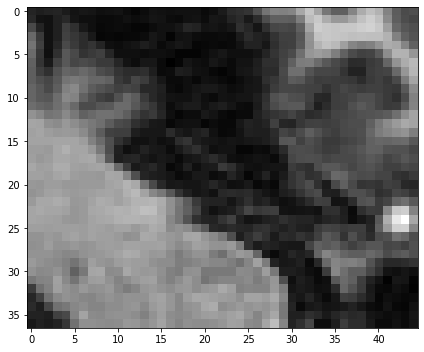

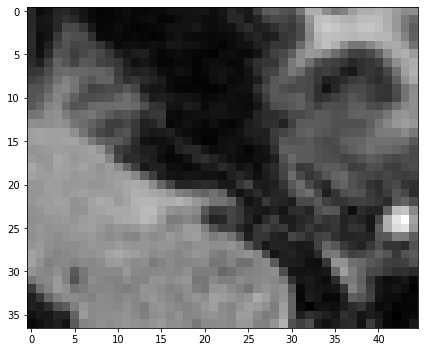

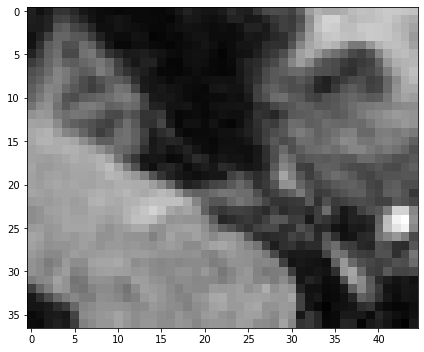

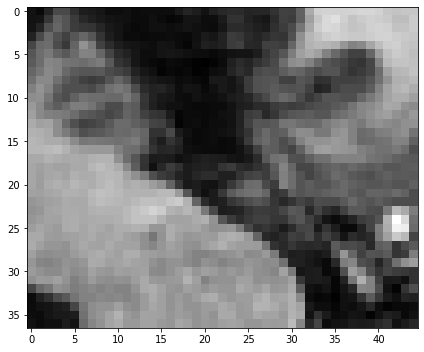

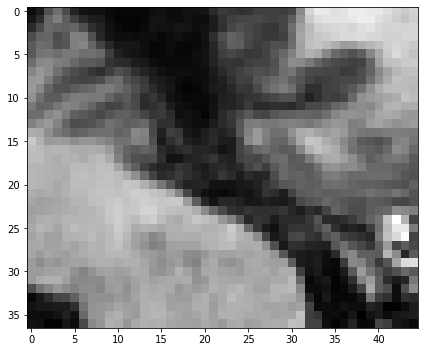

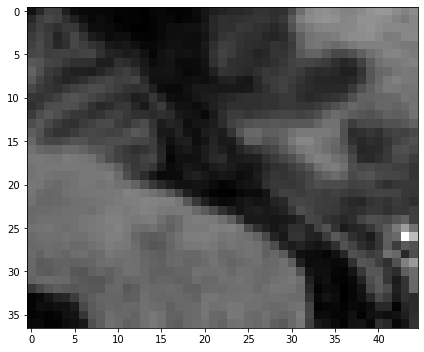

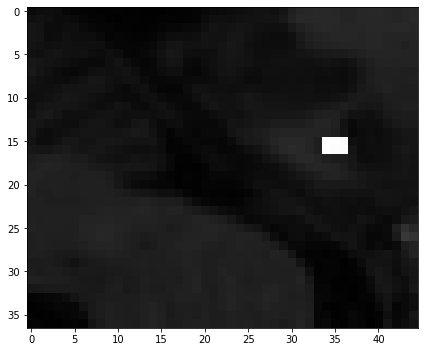

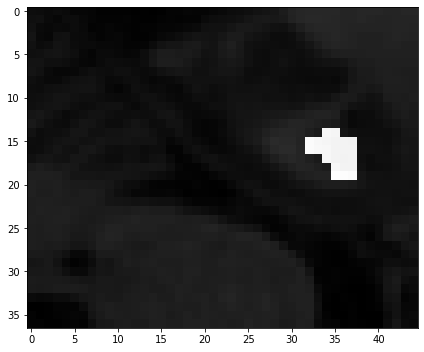

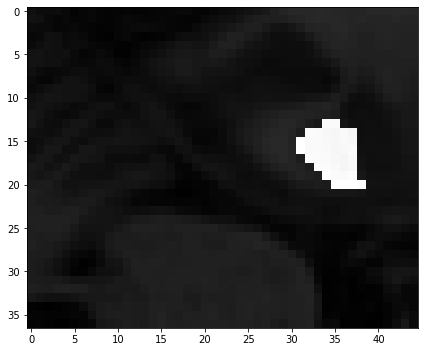

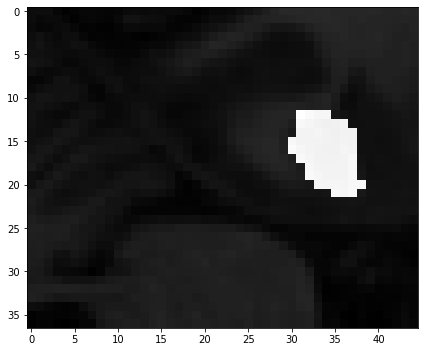

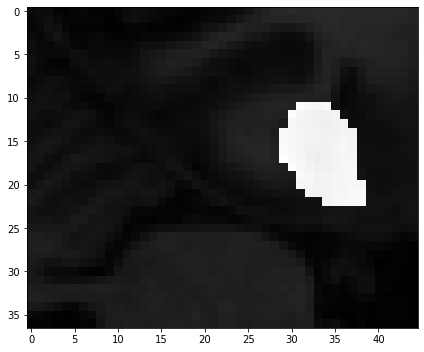

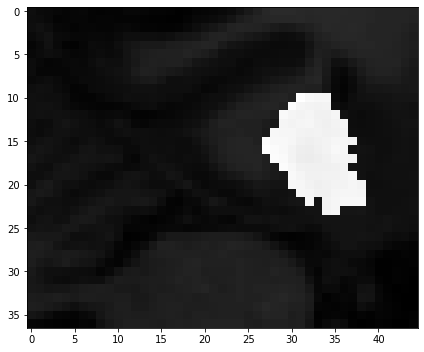

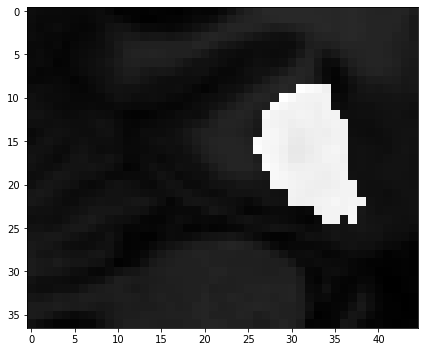

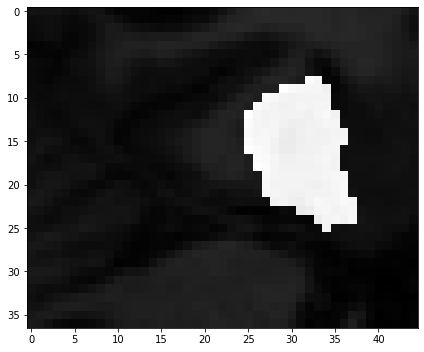

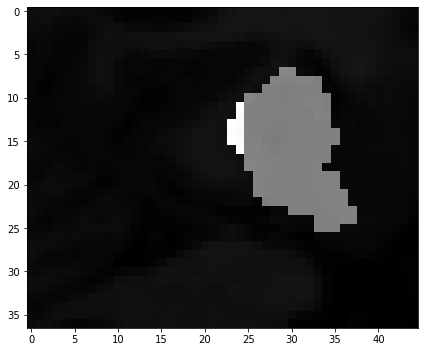

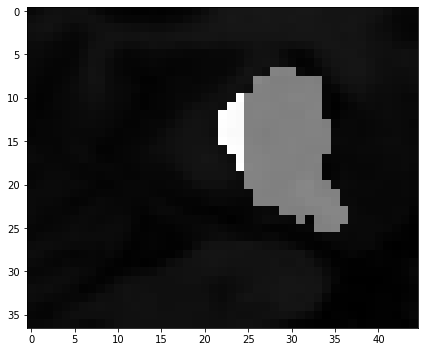

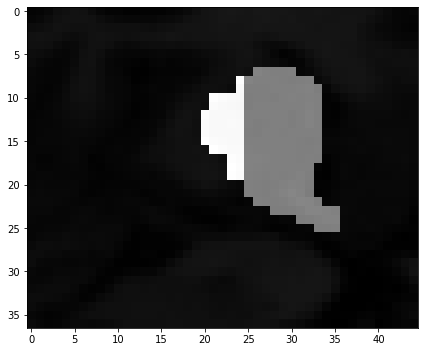

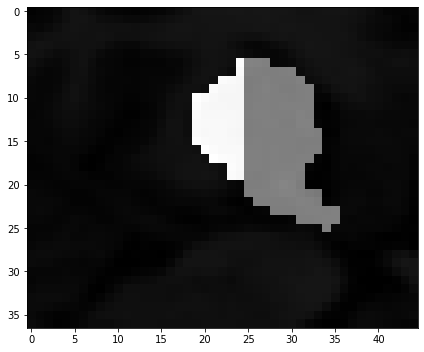

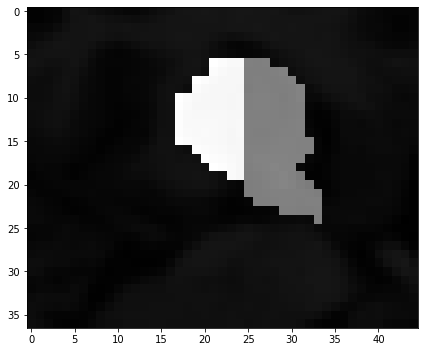

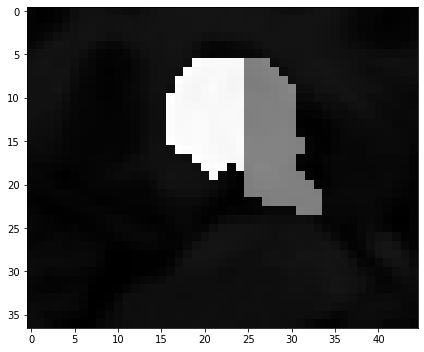

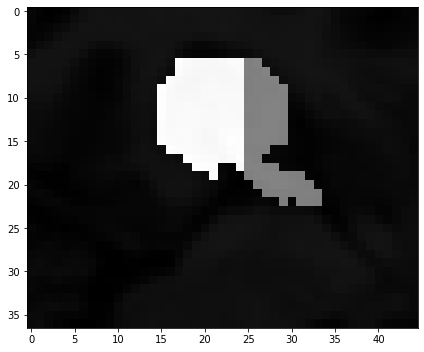

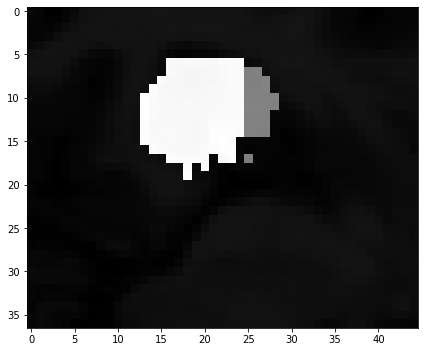

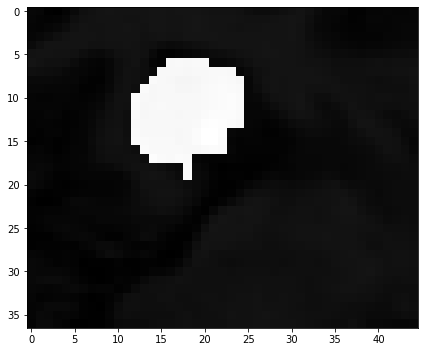

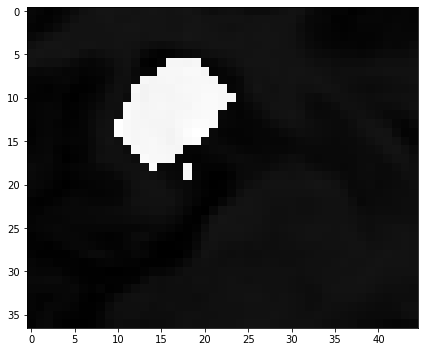

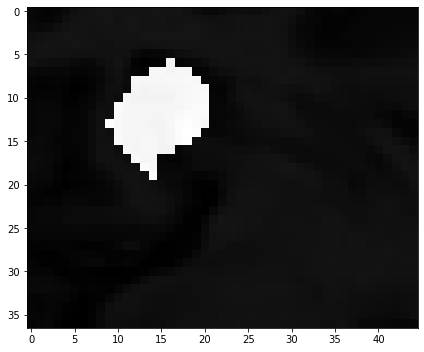

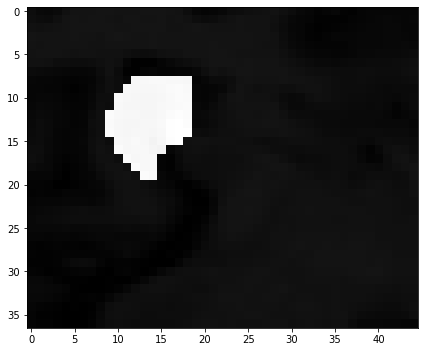

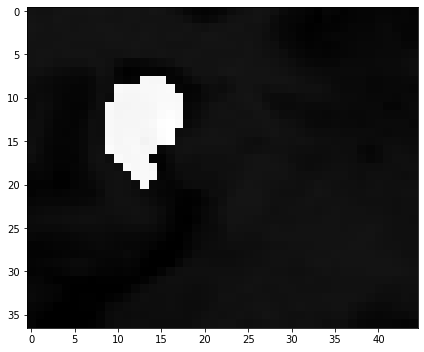

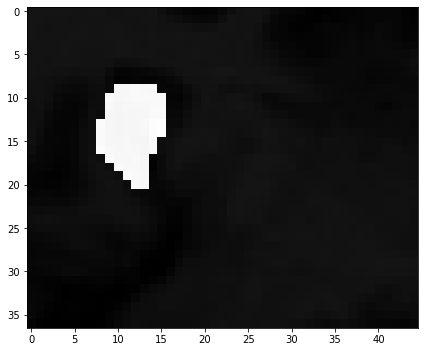

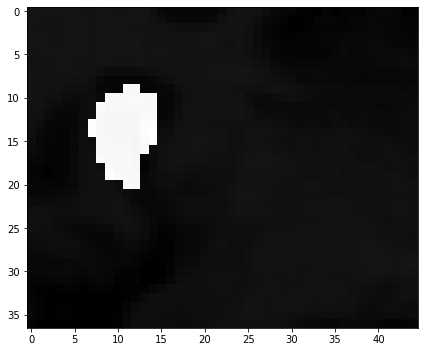

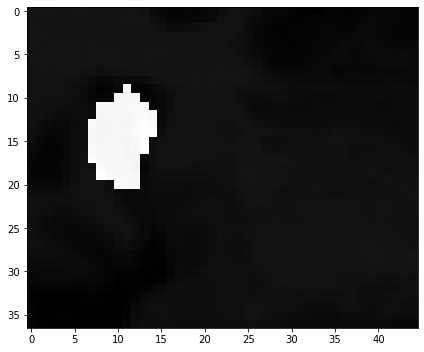

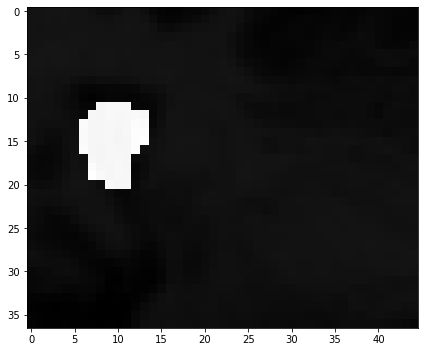

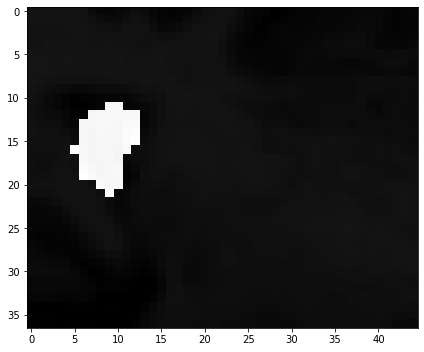

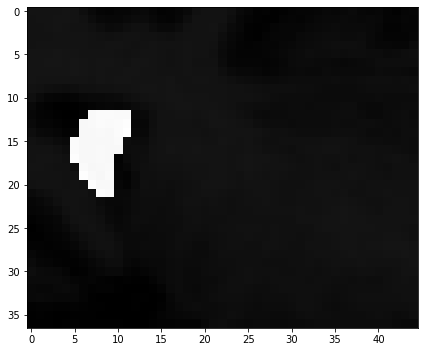

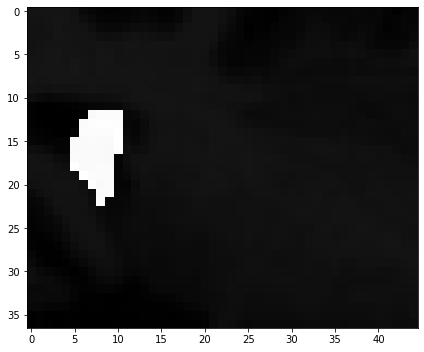

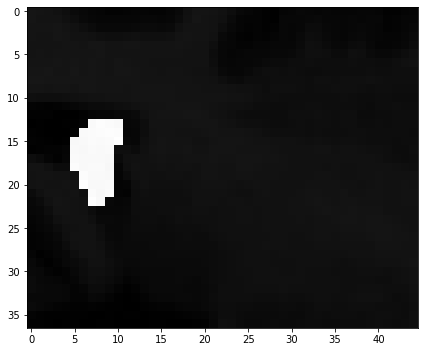

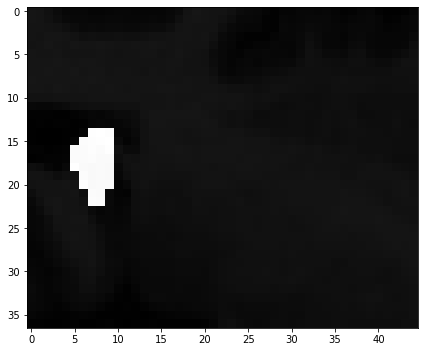

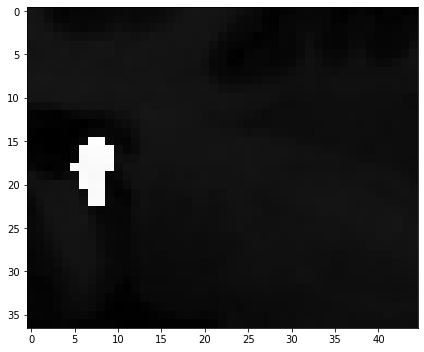

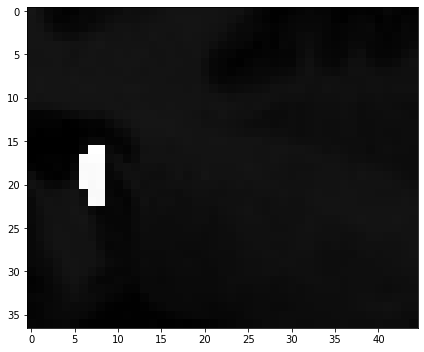

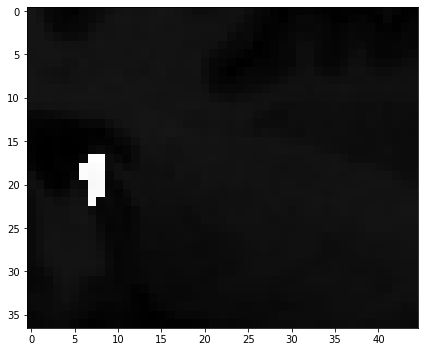

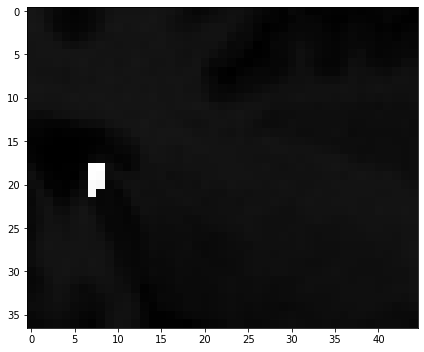

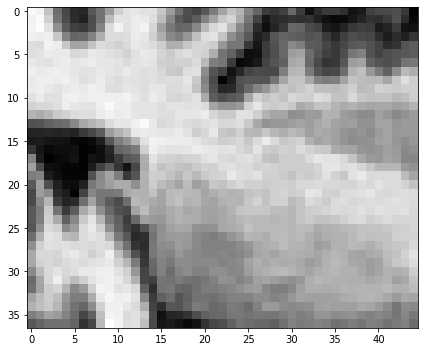

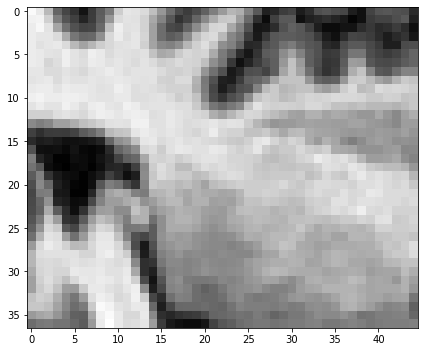

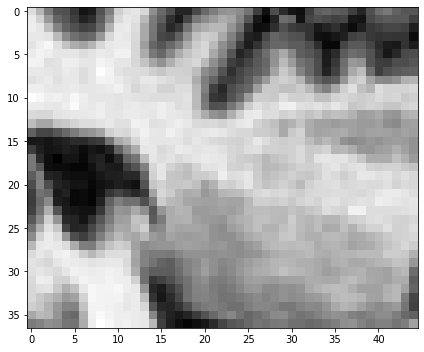

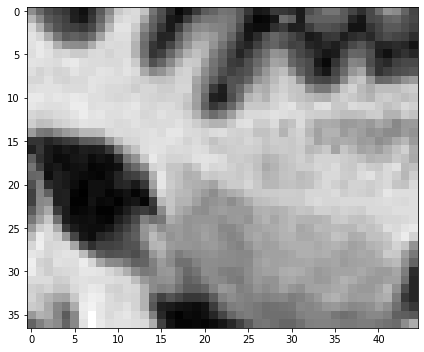

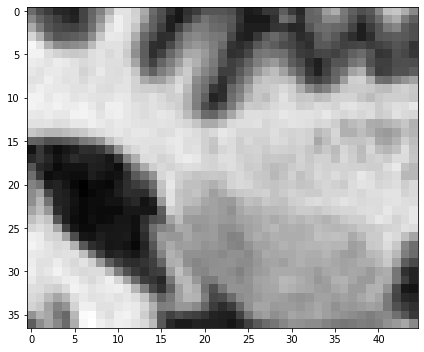

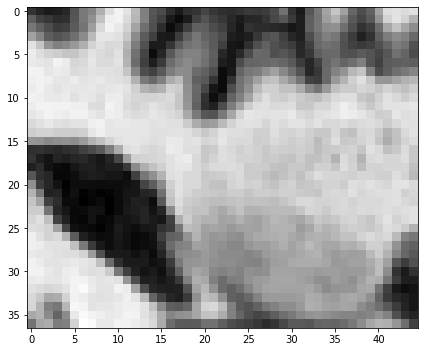

In [7]:
plt.rcParams['figure.figsize'] = (7, 7)
for idx in range(image.shape[2]):
    plt.figure()
    plt.imshow(image[:, :, idx] + label[:, :, idx] * 500, cmap = "gray")

Load volume into 3D Slicer to validate that your visualization is correct and get a feel for the shape of structures.Try to get a visualization like the one below (hint: while Slicer documentation is not particularly great, there are plenty of YouTube videos available! Just look it up on YouTube if you are not sure how to do something)

![3D slicer](img/Slicer.png)

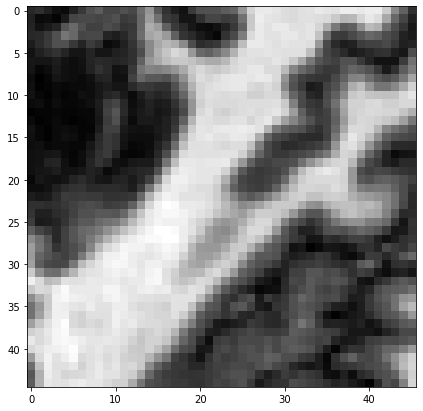

In [8]:
# Stand out suggestion: use one of the simple Volume Rendering algorithms that we've
# implemented in one of our earlier lessons to visualize some of these volumes
nifti_image.shape
plt.imshow(image[0], cmap="gray")

# Volumetric Rendering
in this exercise we will use some methods to visualize the medical volume of the images.
    1. Orthographic projection
    2. maximum intensity projection

## Orthographic projection

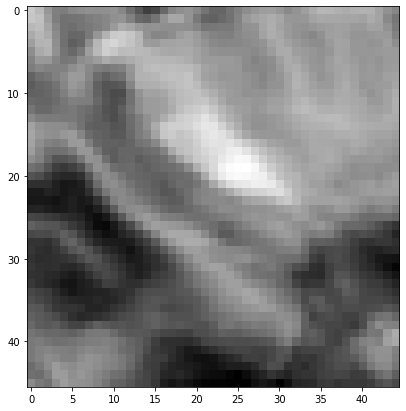

In [9]:
vr = np.zeros((image.shape[1], image.shape[2]))
for x in range(image.shape[0]):
    vr += image[x, :, :]
plt.imshow(nd.rotate(vr, 90), cmap="gray")
    

## maximum intensity projection


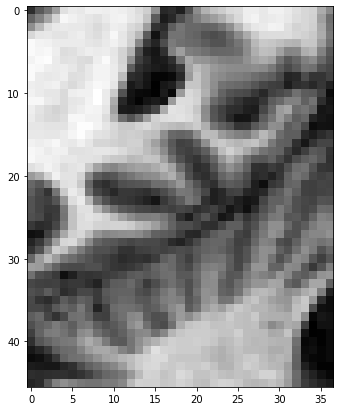

In [10]:
mip = np.zeros((image.shape[0], image.shape[2]))
for y in range(image.shape[1]):
    mip += np.maximum(mip, image[:, y, :])
plt.imshow(nd.rotate(mip, 90), cmap="gray")
    

## Looking at single image data
In this section we will look closer at the NIFTI representation of our volumes. In order to measure the physical volume of hippocampi, we need to understand the relationship between the sizes of our voxels and the physical world.

In [11]:
# Nibabel supports many imaging formats, NIFTI being just one of them. I told you that our images 
# are in NIFTI, but you should confirm if this is indeed the format that we are dealing with
# TASK: using .header_class attribute - what is the format of our images?

nifti_img_head = nifti_image.header
print(nifti_img_head)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [ 3 37 45 46  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b'none'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 1.0
qoffset_y       : 1.0
qoffset_z       : 1.0
srow_x          : [1. 0. 0. 1.]
srow_y          : [0. 

Further down we will be inspecting .header attribute that provides access to NIFTI metadata. You can use this resource as a reference for various fields: https://brainder.org/2012/09/23/the-nifti-file-format/

In [12]:
# TASK: How many bits per pixel are used?
nifti_img_head['bitpix']

array(8, dtype=int16)

The images used an array of 8 bits per pixel

In [13]:
# TASK: What are the units of measurement?
nifti_img_head.get_xyzt_units()

('mm', 'sec')

In [14]:
# TASK: Do we have a regular grid? What are grid spacings?
nifti_img_head['pixdim']

array([1., 1., 1., 1., 1., 0., 0., 0.], dtype=float32)

yes. The nifti format has a regular grid

In [15]:
# TASK: What dimensions represent axial, sagittal, and coronal slices? How do you know?
nifti_img_head['dim']

array([ 3, 37, 45, 46,  1,  1,  1,  1], dtype=int16)

In [16]:
# By now you should have enough information to decide what are dimensions of a single voxel
# TASK: Compute the volume (in mm³) of a hippocampus using one of the labels you've loaded. 
# You should get a number between ~2200 and ~4500
hippocampus_volume = np.sum(label > 0)
print(hippocampus_volume)

3172


## Plotting some charts

(array([35., 54., 79., 68., 22.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 2382. ,  2748.4,  3114.8,  3481.2,  3847.6,  4214. ,  4580.4,
         4946.8,  5313.2,  5679.6,  6046. ,  6412.4,  6778.8,  7145.2,
         7511.6,  7878. ,  8244.4,  8610.8,  8977.2,  9343.6,  9710. ,
        10076.4, 10442.8, 10809.2, 11175.6, 11542. , 11908.4, 12274.8,
        12641.2, 13007.6, 13374. , 13740.4, 14106.8, 14473.2, 14839.6,
        15206. , 15572.4, 15938.8, 16305.2, 16671.6, 17038. , 17404.4,
        17770.8, 18137.2, 18503.6, 18870. , 19236.4, 19602.8, 19969.2,
        20335.6, 20702. ]),
 <a list of 50 Patch objects>)

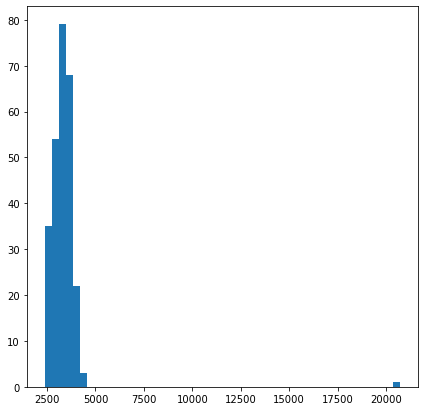

In [17]:
# TASK: Plot a histogram of all volumes that we have in our dataset and see how 
# our dataset measures against a slice of a normal population represented by the chart below.
volumes = list()
for f, l in all_labels.items():
    volume = np.sum(l.get_fdata() > 0)
    volumes.append(volume)
plt.hist(volumes, 50)

<img src="img/nomogram_fem_right.svg" width=400 align=left>

In [18]:
# FINDING THE OUTLIERS FROM THE LABEL
volumes = list()
for f, l in all_labels.items():
    volume = np.sum(l.get_fdata() > 0)
    volumes.append(volume)
    if volume > 4500 or volume < 220:
        print("Volume is: " + str(volume))
        print("files is : " +os.path.join(label_path, f))
    

Volume is: 20702
files is : /data/TrainingSet/labels/hippocampus_281.nii.gz


In [19]:
imagelist = []
for r,d,i in os.walk(img_path):
    for imagefiles in i:
        if imagefiles.endswith(".nii.gz"):
            imagelist.append(imagefiles)
        
labellist = []
for r,d,l in os.walk(label_path):
    for labelfiles in l:
        if labelfiles.endswith(".nii.gz"):
            labellist.append(labelfiles)
missing_files = [x for x in imagelist if x not in labellist]
missing_files.extend([x for x in labellist if x not in imagelist])
print(missing_files)

['hippocampus_118.nii.gz']


In [20]:
#checking for any other outliers in the image files
for f,i in all_images.items():
    img = i.get_fdata()
    img_volume = np.sum(i.get_fdata()>0)
    print(img.shape, img_volume, os.path.join(img_path,f))

(35, 55, 37) 71195 /data/TrainingSet/images/hippocampus_376.nii.gz
(34, 49, 29) 48314 /data/TrainingSet/images/hippocampus_165.nii.gz
(37, 45, 46) 76590 /data/TrainingSet/images/hippocampus_286.nii.gz
(36, 53, 37) 70596 /data/TrainingSet/images/hippocampus_152.nii.gz
(35, 50, 36) 62970 /data/TrainingSet/images/hippocampus_176.nii.gz
(34, 47, 39) 62310 /data/TrainingSet/images/hippocampus_096.nii.gz
(36, 40, 43) 61905 /data/TrainingSet/images/hippocampus_068.nii.gz
(35, 49, 36) 61707 /data/TrainingSet/images/hippocampus_289.nii.gz
(35, 53, 29) 53767 /data/TrainingSet/images/hippocampus_260.nii.gz
(35, 56, 28) 54880 /data/TrainingSet/images/hippocampus_171.nii.gz
(35, 54, 35) 66126 /data/TrainingSet/images/hippocampus_296.nii.gz
(38, 43, 41) 66994 /data/TrainingSet/images/hippocampus_142.nii.gz
(32, 54, 34) 58740 /data/TrainingSet/images/hippocampus_375.nii.gz
(37, 48, 34) 60351 /data/TrainingSet/images/hippocampus_097.nii.gz
(35, 53, 35) 64899 /data/TrainingSet/images/hippocampus_064.ni

(38, 52, 29) 57285 /data/TrainingSet/images/hippocampus_048.nii.gz
(35, 52, 33) 60025 /data/TrainingSet/images/hippocampus_331.nii.gz
(34, 47, 36) 57519 /data/TrainingSet/images/hippocampus_334.nii.gz
(38, 53, 27) 54348 /data/TrainingSet/images/hippocampus_217.nii.gz
(37, 52, 32) 61545 /data/TrainingSet/images/hippocampus_282.nii.gz
(37, 48, 36) 63913 /data/TrainingSet/images/hippocampus_228.nii.gz
(33, 44, 41) 59499 /data/TrainingSet/images/hippocampus_337.nii.gz
(38, 55, 40) 83576 /data/TrainingSet/images/hippocampus_368.nii.gz
(32, 51, 28) 45681 /data/TrainingSet/images/hippocampus_226.nii.gz
(34, 53, 36) 64849 /data/TrainingSet/images/hippocampus_058.nii.gz
(39, 50, 40) 77980 /data/TrainingSet/images/hippocampus_014.nii.gz
(36, 52, 32) 59888 /data/TrainingSet/images/hippocampus_394.nii.gz
(40, 52, 35) 72800 /data/TrainingSet/images/hippocampus_088.nii.gz
(34, 52, 38) 67175 /data/TrainingSet/images/hippocampus_309.nii.gz
(36, 51, 29) 53235 /data/TrainingSet/images/hippocampus_091.ni

In [21]:
#checking for any other outliers in the label files
for f,l in all_labels.items():
    label = l.get_fdata()
    label_volume = np.sum(l.get_fdata()>0)
    print(label.shape, label_volume, os.path.join(label_path,f))

(35, 55, 37) 3581 /data/TrainingSet/labels/hippocampus_376.nii.gz
(34, 49, 29) 3023 /data/TrainingSet/labels/hippocampus_165.nii.gz
(37, 45, 46) 3172 /data/TrainingSet/labels/hippocampus_286.nii.gz
(36, 53, 37) 3994 /data/TrainingSet/labels/hippocampus_152.nii.gz
(35, 50, 36) 2920 /data/TrainingSet/labels/hippocampus_176.nii.gz
(34, 47, 39) 3340 /data/TrainingSet/labels/hippocampus_096.nii.gz
(36, 40, 43) 3000 /data/TrainingSet/labels/hippocampus_068.nii.gz
(35, 49, 36) 2738 /data/TrainingSet/labels/hippocampus_289.nii.gz
(35, 53, 29) 3097 /data/TrainingSet/labels/hippocampus_260.nii.gz
(35, 56, 28) 3674 /data/TrainingSet/labels/hippocampus_171.nii.gz
(35, 54, 35) 3918 /data/TrainingSet/labels/hippocampus_296.nii.gz
(38, 43, 41) 2697 /data/TrainingSet/labels/hippocampus_142.nii.gz
(32, 54, 34) 3222 /data/TrainingSet/labels/hippocampus_375.nii.gz
(37, 48, 34) 2753 /data/TrainingSet/labels/hippocampus_097.nii.gz
(35, 53, 35) 3660 /data/TrainingSet/labels/hippocampus_064.nii.gz
(36, 53, 3

(512, 512, 94) 20702 /data/TrainingSet/labels/hippocampus_281.nii.gz
(33, 51, 34) 3285 /data/TrainingSet/labels/hippocampus_317.nii.gz
(37, 57, 35) 3089 /data/TrainingSet/labels/hippocampus_236.nii.gz
(34, 48, 40) 2870 /data/TrainingSet/labels/hippocampus_170.nii.gz
(35, 47, 45) 3718 /data/TrainingSet/labels/hippocampus_077.nii.gz
(35, 53, 32) 3557 /data/TrainingSet/labels/hippocampus_173.nii.gz
(35, 51, 36) 3728 /data/TrainingSet/labels/hippocampus_049.nii.gz
(38, 52, 33) 3479 /data/TrainingSet/labels/hippocampus_292.nii.gz
(33, 50, 35) 3177 /data/TrainingSet/labels/hippocampus_229.nii.gz
(32, 47, 41) 2532 /data/TrainingSet/labels/hippocampus_335.nii.gz
(34, 51, 31) 3823 /data/TrainingSet/labels/hippocampus_253.nii.gz
(36, 51, 35) 3534 /data/TrainingSet/labels/hippocampus_263.nii.gz
(37, 53, 33) 2943 /data/TrainingSet/labels/hippocampus_314.nii.gz
(33, 47, 38) 3335 /data/TrainingSet/labels/hippocampus_355.nii.gz
(32, 48, 34) 2448 /data/TrainingSet/labels/hippocampus_221.nii.gz
(33, 47

From above we can see that the dimension of image files hippocampus_010.nii.gz & hippocampus_281.nii.gz are out of scope than the rest of image files.

In [22]:
#looking at one of the outliers"hippocampus_281.nii.gz" by checking header information and dimension
image_filename = os.path.join(img_path, "hippocampus_281.nii.gz")
image_check = nib.load(image_filename)
print(image_check.header)


<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512  31   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.       0.785156 0.785156 7.5      0.       0.       0.       0.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -401.21472
qoffset_y       : -401.21472
qoffset

In [23]:
#looking at one of the outliers"hippocampus_010.nii.gz" by checking header information and dimension
label_filename = os.path.join(label_path, "hippocampus_010.nii.gz")
label_check = nib.load(label_filename)
print(label_check.header)


<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [ 3 36 50 31  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b'none'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 1.0
qoffset_y       : 1.0
qoffset_z       : 1.0
srow_x          : [1. 0. 0. 1.]
srow_y          : [0. 

The above observations shows that the following images files are outliers in image directory
    1. hippocampus_010.nii.gz
    2. hippocampus_281.nii.gz
    3. hippocampus_118.nii.gz
    

Do you see any outliers? Why do you think it's so (might be not immediately obvious, but it's always a good idea to inspect) outliers closer. If you haven't found the images that do not belong, the histogram may help you.

In the real world we would have precise information about the ages and conditions of our patients, and understanding how our dataset measures against population norm would be the integral part of clinical validation that we talked about in last lesson. Unfortunately, we do not have this information about this dataset, so we can only guess why it measures the way it is. If you would like to explore further, you can use the [calculator from HippoFit project](http://www.smanohar.com/biobank/calculator.html) to see how our dataset compares against different population slices

Did you notice anything odd about the label files? We hope you did! The mask seems to have two classes, labeled with values `1` and `2` respectively. If you visualized sagittal or axial views, you might have gotten a good guess of what those are. Class 1 is the anterior segment of the hippocampus and class 2 is the posterior one. 

For the purpose of volume calculation we do not care about the distinction, however we will still train our network to differentiate between these two classes and the background

In [24]:
# TASK: Copy the clean dataset to the output folder inside section1/out. You will use it in the next Section


In [25]:
#copying the image dataset to output folder
target_image = "/home/workspace/out/Training"
for imagefile in glob.glob(os.path.join(img_path, "*.nii.gz")):
    shutil.copy(imagefile, target_image)
target_label = "/home/workspace/out/Label"
for labelfile in glob.glob(os.path.join(label_path, "*.nii.gz")):
    shutil.copy(labelfile, target_label)
    

In [26]:
os.remove(os.path.join(target_image, "hippocampus_118.nii.gz"))
os.remove(os.path.join(target_image, "hippocampus_281.nii.gz"))
os.remove(os.path.join(target_image, "hippocampus_010.nii.gz"))

In [27]:
os.remove(os.path.join(target_label, "hippocampus_281.nii.gz"))
os.remove(os.path.join(target_label, "hippocampus_010.nii.gz"))

In [31]:
out_images = np.array([[file for file in files] for _,_,files in os.walk(target_image)])
out_images.shape

(1, 260)

In [32]:
out_labels = np.array([[file for file in files] for _,_,files in os.walk(target_label)])
out_labels.shape

(1, 260)

After removing outliers and ensuring all training images have a corresponding label, we have 260 image files in both the image and label directory.

## Final remarks

Congratulations! You have finished Section 1. 

In this section you have inspected a dataset of MRI scans and related segmentations, represented as NIFTI files. We have visualized some slices, and understood the layout of the data. We have inspected file headers to understand what how the image dimensions relate to the physical world and we have understood how to measure our volume. We have then inspected dataset for outliers, and have created a clean set that is ready for consumption by our ML algorithm. 

In the next section you will create training and testing pipelines for a UNet-based machine learning model, run and monitor the execution, and will produce test metrics. This will arm you with all you need to use the model in the clinical context and reason about its performance!